# BiLSTM Model for predicting magnitude of price change

In [2]:
#imports
import numpy as np
from math import sqrt
from numpy import concatenate

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from matplotlib import pyplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat


import keras.utils
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

import tensorflow as tf
import seaborn as sn
import seed
import os
tf.get_logger().setLevel('ERROR')

In [3]:
"""
method to create lagged features

data - data
to_keep - number of lagged_features
to_remove - number of days to remove

"""
def create_lagged_features(data, to_keep=1, to_remove=1):
    variables = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    columns, names = list(), list()
    
    for i in range(to_keep, 0, -1):
        columns.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(variables)]

    for i in range(0, to_remove):
        columns.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(variables)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(variables)]
            
    #put it all together
    final = concat(columns, axis=1)
    final.columns = names
    
    #drop rows with NaN values
    final.dropna(inplace=True)
        
    return final

In [4]:
"""
function to calculate rsi

data - data
period - RSI period

"""
def rsi(data, period: int = 14):
    
    delta = data["Close"].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    gain = up.ewm(com=(period - 1), min_periods=period).mean()
    loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = gain / loss
    return 100 - (100 / (1 + RS))

In [5]:
#lag granularity - days or hours
lag_granularity = "days"
#lag value
lag = 1
# type of analyser - TextBlob or vader
analyser = "vader"
# analyser = "TextBlob"
#dataset grouped type - day or hour
dataset_grouped_by = "day"

In [6]:
#read dataset
folder = "./../../datasets/tweets_prices_volumes_sentiment/"+analyser+"/"+dataset_grouped_by+"_datasets/cleaned"
filename = folder+"/final_data_lag_"+lag_granularity+"_"+str(lag)+".csv" if (lag > 0) else folder+"/final_data_no_lag.csv"
df = pd.read_csv(filename)

In [9]:
# Нерабочий исходный код
#group by datetime
# df = df.groupby('DateTime').agg(lambda x: x.mean())

# Convert the 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Exclude non-numeric columns ('DateTime' and 'dt') from the aggregation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Perform the aggregation on numeric columns only, grouping by 'DateTime'
df_grouped = df.groupby('DateTime')[numeric_columns].mean()

# Reset the index if you want 'DateTime' back as a column
df_grouped.reset_index(inplace=True)

# Now df_grouped contains the mean of numeric columns, grouped by 'DateTime'


                     DateTime    Close  Volume_(BTC)  Weighted_Price  \
0   2018-08-30 00:00:00+00:00  7027.99      5.484323     6979.227679   
1   2018-08-31 00:00:00+00:00  7187.23      3.694477     7097.021073   
2   2018-09-01 00:00:00+00:00  7275.00      2.830380     7233.487967   
3   2018-09-02 00:00:00+00:00  7301.01      2.130486     7260.380171   
4   2018-09-03 00:00:00+00:00  7357.07      3.392408     7317.186602   
..                        ...      ...           ...             ...   
446 2019-11-19 00:00:00+00:00  8085.36      2.133512     8098.781070   
447 2019-11-20 00:00:00+00:00  7618.17      7.593120     7834.680432   
448 2019-11-21 00:00:00+00:00  7272.99     16.570352     7301.606288   
449 2019-11-22 00:00:00+00:00  7308.09      4.480279     7236.946563   
450 2019-11-23 00:00:00+00:00  7087.81      3.120988     7211.746257   

      neg_pol   neu_pol   pos_pol  compound  Tweet_vol  
0    0.043827  0.825543  0.130654  0.230801      557.0  
1    0.039833  0.8472

In [8]:
#calculate change
df["Change"] = (df["Close"] - df["Close"].shift(1)).astype(float)
#drop empty
df = df.dropna(subset=['Change'])
#max positive change 
max_change = df["Change"].max()
#max negative change 
min_change = df["Change"].min()

#prepare bins
rnge = max_change - min_change
bin_size = (max_change - min_change) / 10
half_range = rnge/2
bins = np.arange(-1*half_range, half_range, bin_size)
bins[5] = 0
bins[0] = float("-inf")
bins = np.append(bins, float("inf"))
#more specific bins
bins = [float("-inf"), -1320, -990, -660, -330, 0., 330, 660, 990, 1320, float("inf")]
labels = [0, 1,2,3,4,5,6,7,8,9]

#set bins
df['Change'] = pd.cut(x=df['Change'], bins=bins, labels=labels, include_lowest=True)

add_RSI = False
add_longMAvg = False
add_shortMAvg = False

if(add_RSI):
    #calcualte RSI
    RSI = 14
    df['RSI'] = rsi(df, RSI)
    df = df.iloc[RSI:]

#calculate moving averages
if(add_shortMAvg):
    short_window = 9
    df['short_mavg'] = df.rolling(window=short_window)["Close"].mean()
    
if(add_longMAvg):
    long_window = 21
    df["long_mavg"] = df.rolling(window=long_window)["Close"].mean()
    
if(add_longMAvg):
    df = df.iloc[long_window:]
elif(add_RSI):
    df = df.iloc[RSI:]
elif(add_shortMAvg):
    df = df.iloc[short_window:]

C:\Users\igor\AppData\Local\Temp\ipykernel_16872\1592310159.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Change'] = pd.cut(x=df['Change'], bins=bins, labels=labels, include_lowest=True)


In [9]:
#keep only wanted columns
features = ['Change', 'subjectivity', 'polarity','Tweet_vol','Volume_(BTC)'] if analyser == "Textblob" else ['Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']

if(add_RSI):
    features.append("RSI")
    
if(add_longMAvg):
    features.append("long_mavg")
    
if(add_shortMAvg):
    features.append("short_mavg")

df = df[features]

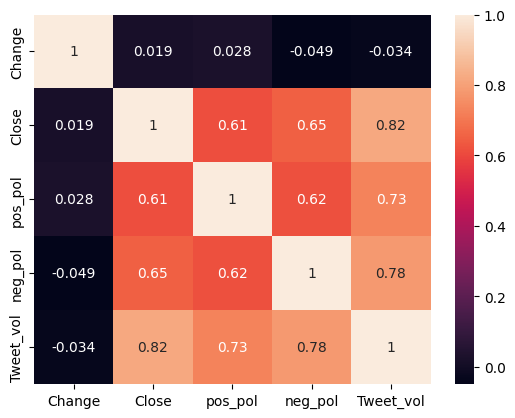

In [10]:
#plot correlation matrix
sn.heatmap(df.corr(), annot=True)
plt.show()

In [11]:
#creating copy so that data is not loaded once again
df_copy = df.copy()

In [12]:
#number of previous records to consider for every example
n_lag = 14
#number of features
n_features = len(features)
#calculate total_features
total_features = n_lag*n_features

if(total_features == 0):
    total_features = n_features

In [13]:
bins

[-inf, -1320, -990, -660, -330, 0.0, 330, 660, 990, 1320, inf]

In [17]:
#add lagged data to records
data_with_lagged = create_lagged_features(df_copy, n_lag, 1)
# Check the column names of the DataFrame after creating lagged features

data_with_lagged = data_with_lagged.reset_index()

# Нерабочий исходный код
# data_with_lagged = data_with_lagged.drop(['DateTime'], axis=1)

data_with_lagged = data_with_lagged.drop(['index'], axis=1)

In [18]:
#shuffle data
np.random.seed(1)
#shuffle times 
shuffle_times = 3;
for j in range(0, shuffle_times+1):
    data_with_lagged = shuffle(data_with_lagged)

In [19]:
#divide df into train and test
train_ratio = 0.85
data_len = len(data_with_lagged)
train_size = int(data_len*train_ratio)

train = data_with_lagged.iloc[:train_size]
test = data_with_lagged.iloc[train_size:]

In [20]:
#prepare labels
train_y = train["var1(t)"].values
test_y = test["var1(t)"].values

In [21]:
#normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
train = xscaler.fit_transform(train)
test = xscaler.transform(test)

In [22]:
#prepare data
train_labels = train_y
test_labels = test_y

In [23]:
#remove the last set of values(data of time to be predicted)
train = train[:, :total_features]
test = test[:, :total_features]

In [24]:
#keep only prices array
train_X, train_y = train[:, :total_features], train_y
test_X, test_y = test[:, :total_features], test_y

In [25]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

In [26]:
#set labels for training data to categorical
train_y = keras.utils.to_categorical(train_y, 10)

In [27]:
#set random to reproduce results
np.random.seed(1)
tf.random.set_seed(1)

# design network
model = Sequential()
neurons = 256
epochs = 1000
dropout = 0.25
batch_size = 80
activ_func = "linear"

model.add(Bidirectional(LSTM(neurons, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), activation=activ_func)))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(neurons, return_sequences=False, activation=activ_func)))
model.add(Dropout(dropout))

model.add(Dense(10, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# early stopping callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience =20)

# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False,validation_split=0.2)

Epoch 1/1000
4/4 - 4s - loss: 1.9294 - accuracy: 0.3243 - val_loss: 1.5586 - val_accuracy: 0.3919 - 4s/epoch - 1s/step
Epoch 2/1000
4/4 - 0s - loss: 1.3982 - accuracy: 0.4291 - val_loss: 1.3075 - val_accuracy: 0.4595 - 274ms/epoch - 68ms/step
Epoch 3/1000
4/4 - 0s - loss: 1.2964 - accuracy: 0.4696 - val_loss: 1.1924 - val_accuracy: 0.4595 - 276ms/epoch - 69ms/step
Epoch 4/1000
4/4 - 0s - loss: 1.2292 - accuracy: 0.4358 - val_loss: 1.1356 - val_accuracy: 0.4865 - 254ms/epoch - 64ms/step
Epoch 5/1000
4/4 - 0s - loss: 1.2419 - accuracy: 0.4358 - val_loss: 1.1396 - val_accuracy: 0.4459 - 258ms/epoch - 65ms/step
Epoch 6/1000
4/4 - 0s - loss: 1.1994 - accuracy: 0.4257 - val_loss: 1.1344 - val_accuracy: 0.4324 - 259ms/epoch - 65ms/step
Epoch 7/1000
4/4 - 0s - loss: 1.2090 - accuracy: 0.4358 - val_loss: 1.1386 - val_accuracy: 0.4730 - 266ms/epoch - 67ms/step
Epoch 8/1000
4/4 - 0s - loss: 1.1858 - accuracy: 0.4358 - val_loss: 1.1517 - val_accuracy: 0.4865 - 256ms/epoch - 64ms/step
Epoch 9/1000


In [29]:
model_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


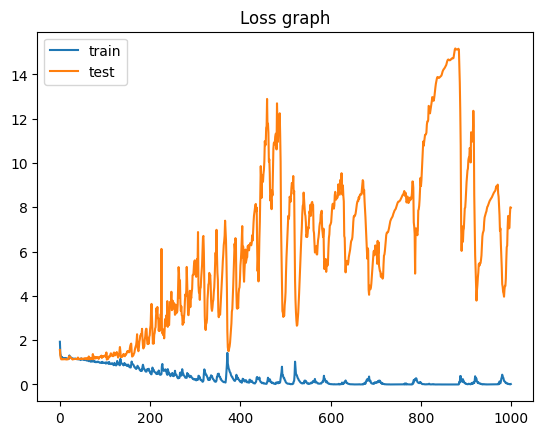

In [30]:
#plot loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss graph")
plt.show()

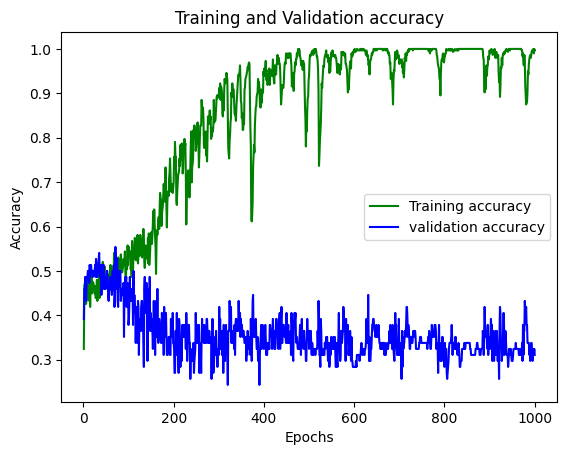

In [31]:
#plot training and validation accuracy
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,len(loss_val) + 1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
#reshape
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

#predict values for test data
pred = model.predict(test_X)

#reshape again
test_X = test_X.reshape((test_X.shape[0], n_lag* n_features,))

3/3 [==============================] - 0s 7ms/step


In [33]:
#change back from categorical
pred = np.argmax(pred, axis=1)

In [43]:
#calculate accuracy
prices = pd.DataFrame()

# Нерабочий исходный код
# prices["Actual"] = test_y
# prices["Predicted"] = pred

prices["Actual"] = pd.to_numeric(test_y)
prices["Predicted"] = pd.to_numeric(pred)

prices["Correct"] = (prices["Actual"] - prices["Predicted"]) == 0
incorrect = prices.loc[prices['Correct'] == False]
incorrect_len = len(incorrect)
prices_len = len(prices)

print("Accuracy = ",((prices_len-incorrect_len)/prices_len))

Accuracy =  0.3787878787878788
